# 4. Top-N Simulations from Actual Experimental Data

This notebook loads an existing Beer1pos data, runs it through the simulator and compares the simulated results to the initial input data. The results here correspond to Section 3.2 in the paper.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import pylab as plt
import pymzml

In [3]:
import sys
sys.path.append('..')

In [4]:
from vimms.Roi import RoiToChemicalCreator, make_roi
from vimms.DataGenerator import DataSource, PeakDensityEstimator, PeakSampler
from vimms.MassSpec import IndependentMassSpectrometer
from vimms.Controller import TopNController
from vimms.PlotsForPaper import count_stuff, plot_num_scans, match_peaklist, check_found_matches, \
plot_matched_intensities, plot_matched_precursors
from vimms.Common import *

In [5]:
set_log_level_info()

## 1. Parameters

In [6]:
base_dir = 'example_data'
mzml_path = os.path.join(base_dir, 'beers\\fragmentation\\mzML')
file_name = 'Beer_multibeers_1_T10_POS.mzML'

experiment_name = 'mzml_compare'
experiment_out_dir = os.path.join(base_dir, 'results', experiment_name)

In [7]:
min_rt = 0
max_rt = 1441

In [8]:
kde_min_ms1_intensity = 0 # min intensity to be selected for kdes
kde_min_ms2_intensity = 0

### a. ROI extraction parameters

In [9]:
roi_mz_tol = 10
roi_min_length = 1
roi_min_intensity = 0
roi_start_rt = min_rt
roi_stop_rt = max_rt

### b. Top-N parameters

In [10]:
isolation_window = 1   # the isolation window in Dalton around a selected precursor ion
ionisation_mode = POSITIVE
N = 10
rt_tol = 15
mz_tol = 10
min_ms1_intensity = 1.75E5 # minimum ms1 intensity to fragment

In [11]:
mzml_out = os.path.join(experiment_out_dir, 'simulated.mzML')

## 2. Train densities

In [12]:
ds = DataSource()
ds.load_data(mzml_path, file_name=file_name)

INFO   : DataSource                     : Loading Beer_multibeers_1_T10_POS.mzML


example_data\beers\fragmentation\mzML\Beer_multibeers_1_T10_POS.mzML


In [13]:
# ds.plot_data(file_name, ms_level=1, max_data=100000, min_rt=min_rt, max_rt=max_rt)

In [14]:
# ds.plot_data(file_name, ms_level=2, max_data=100000, min_rt=min_rt, max_rt=max_rt)

In [15]:
densities = PeakDensityEstimator(kde_min_ms1_intensity, kde_min_ms2_intensity, min_rt, max_rt)
densities.kde(ds, file_name, 2, bandwidth_mz_intensity_rt=1.0, bandwidth_n_peaks=1.0)
ps = PeakSampler(densities)

INFO   : DataSource                     : Using values from scans


## 3. Extract all ROIs

In [16]:
mzml_file = os.path.join(mzml_path, file_name)
good_roi, junk = make_roi(mzml_file, mz_tol=roi_mz_tol, mz_units='ppm', min_length=roi_min_length,
                          min_intensity=roi_min_intensity, start_rt=roi_start_rt, stop_rt=roi_stop_rt)

example_data\beers\fragmentation\mzML\Beer_multibeers_1_T10_POS.mzML


In [17]:
all_roi = good_roi + junk
len(all_roi)

512540

How many singleton and non-singleton ROIs?

In [18]:
len([roi for roi in all_roi if roi.n == 1])

352967

In [19]:
len([roi for roi in all_roi if roi.n > 1])

159573

Keep only the ROIs that can be fragmented above **min_ms1_intensity threshold**.

In [20]:
min_ms1_intensity

175000.0

In [21]:
keep = []
for roi in all_roi:
    if np.count_nonzero(np.array(roi.intensity_list) > min_ms1_intensity) > 0:
        keep.append(roi)

all_roi = keep
len(keep)

10190

Turn ROIs into chromatograms/chemicals

In [22]:
set_log_level_debug()
rtcc = RoiToChemicalCreator(ps, all_roi)

DEBUG  : RoiToChemicalCreator           :      0/ 10190
INFO   : RoiToChemicalCreator           : Found 10190 ROIs above thresholds


In [23]:
data = rtcc.chemicals
save_obj(data, os.path.join(experiment_out_dir, 'dataset.p'))

Created example_data\results\mzml_compare
Saving <class 'list'> to example_data\results\mzml_compare\dataset.p


## 4. Run Top-N Controller

In [24]:
density = ps.density_estimator
set_log_level_warning()
pbar = True

In [25]:
mass_spec = IndependentMassSpectrometer(ionisation_mode, data, density=density)
controller = TopNController(mass_spec, N, isolation_window, mz_tol,
                            rt_tol, min_ms1_intensity)
controller.run(min_rt, max_rt, pbar)

1441.0074379999917it [01:39, 14.44it/s]                                                                                           


In [26]:
controller.write_mzML('my_analysis', mzml_out)

In [27]:
mzml_out

'example_data\\results\\mzml_compare\\simulated.mzML'

## 5. Compare Results

### Load simulated and real data.

In [28]:
simulated_input_file = mzml_out
simulated_mzs, simulated_rts, simulated_intensities, simulated_cumsum_ms1, simulated_cumsum_ms2 = count_stuff(
    simulated_input_file, min_rt, max_rt)

example_data\results\mzml_compare\simulated.mzML
Number of ms1 scans = 1269
Number of ms2 scans = 8631
Total scans = 9900
Number of selected precursors = 8631


In [29]:
real_input_file = mzml_file
real_mzs, real_rts, real_intensities, real_cumsum_ms1, real_cumsum_ms2 = count_stuff(
    real_input_file, min_rt, max_rt)

example_data\beers\fragmentation\mzML\Beer_multibeers_1_T10_POS.mzML
Number of ms1 scans = 1751
Number of ms2 scans = 7655
Total scans = 9406
Number of selected precursors = 7672


### Plot number of scans

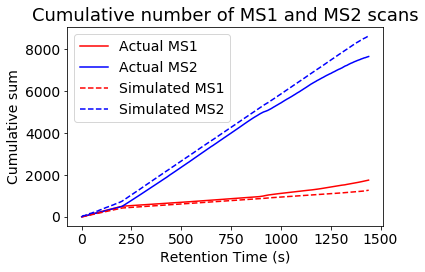

In [30]:
plt.rcParams.update({'font.size': 14})
out_file = os.path.join(base_dir, 'results', 'topN_num_scans.png')
plot_num_scans(real_cumsum_ms1, real_cumsum_ms2, simulated_cumsum_ms1, simulated_cumsum_ms2, out_file)

### Check the number of precursors that could be matched at different m/z and RT tolerances

In [31]:
mz_tol = None # in ppm. if None, then 2 decimal places is used for matching the m/z
rt_tol = 5 # seconds
matches = match_peaklist(real_mzs, real_rts, real_intensities, simulated_mzs, simulated_rts, simulated_intensities, mz_tol, rt_tol)
check_found_matches(matches, 'Real', 'Simulated')

Found 4880/7655 (0.637492)
Real						Simulated
mz 144.98 rt 0.6005 intensity 1548081.2500	mz 144.98 rt 0.5845 intensity 1789799.5699
mz 207.16 rt 0.7352 intensity 1443976.8750	mz 207.16 rt 0.7185 intensity 1538437.9173
mz 126.05 rt 0.8693 intensity 1087971.0000	mz 126.05 rt 0.8485 intensity 1392625.1901
mz 146.98 rt 1.0029 intensity 727259.1875	mz 146.98 rt 1.0925 intensity 832245.7860
mz 224.19 rt 1.1375 intensity 395470.6562	mz 224.19 rt 1.5005 intensity 410232.4545
mz 338.34 rt 1.2750 intensity 385685.9688	mz 338.34 rt 1.3675 intensity 424409.8945
mz 116.07 rt 1.4077 intensity 366917.8750	mz 116.07 rt 1.2275 intensity 523436.5839
mz 131.13 rt 1.5412 intensity 322462.5000	mz 131.13 rt 1.6335 intensity 398446.2790
mz 104.11 rt 1.6740 intensity 267410.7188	mz 104.11 rt 1.7705 intensity 347909.1517
mz 228.20 rt 2.0738 intensity 605814.3125	mz 228.20 rt 2.4598 intensity 605721.3932
mz 162.08 rt 2.2073 intensity 955391.5000	mz 162.08 rt 1.9065 intensity 343757.6532
mz 128.95 rt 2.4319 int

In [32]:
mz_tol = None
rt_tol = 10
matches = match_peaklist(real_mzs, real_rts, real_intensities, simulated_mzs, simulated_rts, simulated_intensities, mz_tol, rt_tol)
check_found_matches(matches, 'Real', 'Simulated')

Found 6545/7655 (0.854997)
Real						Simulated
mz 144.98 rt 0.6005 intensity 1548081.2500	mz 144.98 rt 0.5845 intensity 1789799.5699
mz 207.16 rt 0.7352 intensity 1443976.8750	mz 207.16 rt 0.7185 intensity 1538437.9173
mz 126.05 rt 0.8693 intensity 1087971.0000	mz 126.05 rt 0.8485 intensity 1392625.1901
mz 146.98 rt 1.0029 intensity 727259.1875	mz 146.98 rt 1.0925 intensity 832245.7860
mz 224.19 rt 1.1375 intensity 395470.6562	mz 224.19 rt 1.5005 intensity 410232.4545
mz 338.34 rt 1.2750 intensity 385685.9688	mz 338.34 rt 1.3675 intensity 424409.8945
mz 116.07 rt 1.4077 intensity 366917.8750	mz 116.07 rt 1.2275 intensity 523436.5839
mz 131.13 rt 1.5412 intensity 322462.5000	mz 131.13 rt 1.6335 intensity 398446.2790
mz 104.11 rt 1.6740 intensity 267410.7188	mz 104.11 rt 1.7705 intensity 347909.1517
mz 228.20 rt 2.0738 intensity 605814.3125	mz 228.20 rt 2.4598 intensity 605721.3932
mz 162.08 rt 2.2073 intensity 955391.5000	mz 162.08 rt 1.9065 intensity 343757.6532
mz 128.95 rt 2.4319 int

In [33]:
mz_tol = None
rt_tol = 15
matches = match_peaklist(real_mzs, real_rts, real_intensities, simulated_mzs, simulated_rts, simulated_intensities, mz_tol, rt_tol)
check_found_matches(matches, 'Real', 'Simulated')

Found 6775/7655 (0.885042)
Real						Simulated
mz 144.98 rt 0.6005 intensity 1548081.2500	mz 144.98 rt 0.5845 intensity 1789799.5699
mz 207.16 rt 0.7352 intensity 1443976.8750	mz 207.16 rt 0.7185 intensity 1538437.9173
mz 126.05 rt 0.8693 intensity 1087971.0000	mz 126.05 rt 0.8485 intensity 1392625.1901
mz 146.98 rt 1.0029 intensity 727259.1875	mz 146.98 rt 1.0925 intensity 832245.7860
mz 224.19 rt 1.1375 intensity 395470.6562	mz 224.19 rt 1.5005 intensity 410232.4545
mz 338.34 rt 1.2750 intensity 385685.9688	mz 338.34 rt 1.3675 intensity 424409.8945
mz 116.07 rt 1.4077 intensity 366917.8750	mz 116.07 rt 1.2275 intensity 523436.5839
mz 131.13 rt 1.5412 intensity 322462.5000	mz 131.13 rt 1.6335 intensity 398446.2790
mz 104.11 rt 1.6740 intensity 267410.7188	mz 104.11 rt 1.7705 intensity 347909.1517
mz 228.20 rt 2.0738 intensity 605814.3125	mz 228.20 rt 2.4598 intensity 605721.3932
mz 162.08 rt 2.2073 intensity 955391.5000	mz 162.08 rt 1.9065 intensity 343757.6532
mz 128.95 rt 2.4319 int

### Plot the matches

In [34]:
unmatched_intensities = []
matched_intensities = []
for key, value in list(matches.items()):
    intensity = key[2]
    if value is None:
        unmatched_intensities.append(intensity)
    else:
        matched_intensities.append(intensity)

In [35]:
plt.rcParams.update({'font.size': 18})   

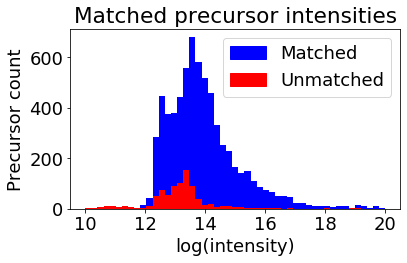

In [36]:
out_file = os.path.join(base_dir, 'results', 'topN_matched_intensities.png')
plot_matched_intensities(matched_intensities, unmatched_intensities, out_file)

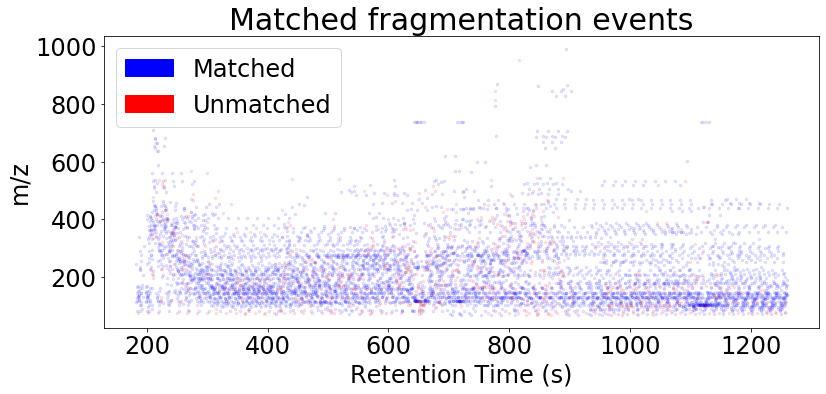

In [37]:
out_file = os.path.join(base_dir, 'results', 'topN_matched_precursors.png')
plot_matched_precursors(matches, 50, 1000, 180, 1260, out_file)